*Copyright 2023 Google LLC.*

*Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at*

     http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.*

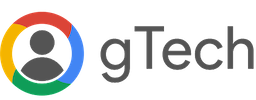

# **Phoebe - Vertex AI demo - Lead score case study**

# **Requirements**

1. Admin access to a GCP project.
2. Some Terminal experience.
3. Some Python experience.
4. Some experience with Jupyter notebooks.
5. Access to Vertex AI Workbench to run this notebook. See [here](https://cloud.google.com/vertex-ai-notebooks) to learn more about Vertex AI Workbench.

# **Introduction**

Phoebe is a solution that leverages AI/ML models to make predictions based on sGTM data.

This notebook is a demo showing how to use Google Cloud Vertex AI to train a model, evaluate it and deploy to an endpoint in a single pipeline.

**THE NOTEBOOK IS FOR DEMO PURPOSES ONLY. IT MIGHT NOT REPRESENT ALL THE BEST PRACTICES AND THE CODE FROM HERE SHOULD NOT BE DEPLOYED INTO PRODUCTION.**

**YOU TAKE RESPONSIBILITY FOR THE GCP COSTS ASSOCIATED WITH RUNNING THIS NOTEBOOK.**

**THIS IS NOT AN OFFICIAL GOOGLE PRODUCT.**

# **Case study**

This notebook demos a case study where an advertiser would use sGTM data to predict lead score for lead gen when a user signs up form.

The notebook will use syntehtic data generated in the cells below.

# **Installs**

The first step is to generate a file with package equirements (it will be used later to create a Docker image) and then install the required packages in this notebook.

In [1]:
%%writefile requirements.txt
scikit-learn == 1.2.2
pandas == 1.5.3
numpy == 1.23.5
tensorflow == 2.13.0
google-cloud-aiplatform[prediction] >= 1.16.0
google-cloud-bigquery == 3.10.0
google-cloud-bigquery-connection == 1.12.1
google-cloud-bigquery-storage == 2.22.0
google-cloud-core == 2.3.3
google-cloud-functions == 1.13.2
google-cloud-storage == 2.8.0
grpcio-status == 1.48.2
db-dtypes == 1.1.1
fsspec == 2023.6.0
gcsfs == 2023.6.0
kfp == 2.0.1

Writing requirements.txt


In [3]:
!pip install -r requirements.txt

**Remember to restart your runtime (kernel) after the installation.**

# **Imports**

Next step is to import all the Python libraries required to run all the cells in this notebook. You shouldn't need to import anything later on.

In [4]:
import json
import os
import pickle
from typing import Any, Final, Mapping, NamedTuple, Sequence
from google.cloud import bigquery
from google.cloud import exceptions
from google.cloud.aiplatform import pipeline_jobs
from google.cloud.aiplatform.prediction import local_model
from google.cloud.aiplatform.utils import prediction_utils
from google.cloud.bigquery import enums
from kfp import compiler
from kfp import dsl
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
import random

2024-04-21 08:29:09.720251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **[YOUR INPUT/ACTION NEEDED] - GCP SETUP**

**NO CODE, OTHER THAN IN THIS SECTION, SHOULD BE CHANGED TO RUN THIS NOTBEOOK SUCCESSFULLY.**

In [9]:
# E.g. "demo_modules"  (A name for a local directory where demo code chunks are
# going to be saved)
_DEMO_MODULES_DIRECTORY: Final[str] = "demo_modules"

# E.g. "custom_predictor"  (A name for a local directory where Custom Predictor
# artifacts are going to be saved)
_CUSTOM_PREDICTOR_DIRECTORY: Final[str] = "custom_predictor"

# E.g. "demo-project" (Your GCP project id)
_GCP_PROJECT_ID: Final[str] = ""

# E.g. "01234567891" (Your GCP project number)
_GCP_PROJECT_NUMBER: Final[str] = ""

# E.g. "europe-west1" (A region name for your GCP resources, should match the region of the other components)
_GCP_REGION: Final[str] = ""

# E.g. "demo-bucket" (A name for your GCS bucket)
_GCP_BUCKET_NAME: Final[str] = ""

# E.g. "eu" (A location name of your GCS bucket)
_GCP_BUCKET_LOCATION: Final[str] = ""

# E.g. "gs://demo-bucket/demo" (A GCS directory name where all artifacts
# are going to be saved)
_EXPERIMENT_DIRECTORY: Final[str] = os.path.join("gs://", _GCP_BUCKET_NAME, "demo")

# E.g. "demo_dataset" (A name for your BigQuery dataset)
_BIGQUERY_DATASET_NAME: Final[str] = "demo_dataset"

# E.g. "demoartifactrepository" (A name for your Artifact Registry repository)
_GCP_ARTIFACT_REPOSITORY: Final[str] = "demoartifactrepository"

# E.g. "demopredictor:latest" (A Docker image name for your Custom Predictor)
_GCP_PREDICTOR_IMAGE_NAME: Final[str] = "demopredictor:latest"

# E.g. "gs://demo-bucket/demo/pipeline" (A GCS directory name where all
# pipeline artifacts are going to be saved)
_GCP_PIPELINE_ROOT: Final[str] = os.path.join(_EXPERIMENT_DIRECTORY, "pipeline")

# E.g. "demo-end-to-end"  (A name for your Vertex AI pipeline)
_GCP_PIPELINE_NAME: Final[str] = "demo-end-to-end"

# E.g. "demopipeline:latest". (A Docker image name for your Vertex AI pipeline)
_GCP_PIPELINE_IMAGE_NAME: Final[str] = "demopipeline:latest"

# E.g. "demo_model"  (A name for your model in Vertex AI)
_GCP_MODEL_DISPLAY_NAME: Final[str] = "demo_model"

# E.g. "demo_model_endpoint"  (A name for your Vertex AI endpoint)
_GCP_ENDPOINT_DISPLAY_NAME: Final[str] = "demo_model_endpoint"

# No input needed here
_PIPELINE_DOCKER_IMAGE: Final[str] = (
    f"{_GCP_REGION}-docker.pkg.dev/{_GCP_PROJECT_ID}/{_GCP_ARTIFACT_REPOSITORY}/{_GCP_PIPELINE_IMAGE_NAME}"
)
# No input needed here
_PREDICTOR_IMAGE: Final[str] = (
    f"{_GCP_REGION}-docker.pkg.dev/{_GCP_PROJECT_ID}/{_GCP_ARTIFACT_REPOSITORY}/{_GCP_PREDICTOR_IMAGE_NAME}"
)

Some of the above variables need to become environment variables to run terminal commands.

In [10]:
os.environ["GCP_PROJECT_ID"] = _GCP_PROJECT_ID
os.environ["CUSTOM_PREDICTOR_DIRECTORY"] = _CUSTOM_PREDICTOR_DIRECTORY
os.environ["GCP_ARTIFACT_REPOSITORY"] = _GCP_ARTIFACT_REPOSITORY
os.environ["GCP_REGION"] = _GCP_REGION
os.environ["GCP_PROJECT_NUMBER"] = _GCP_PROJECT_NUMBER
os.environ["GCP_PIPELINE_IMAGE_NAME"] = _GCP_PIPELINE_IMAGE_NAME
os.environ["GCP_BUCKET_NAME"] = _GCP_BUCKET_NAME

You need to set the above environment variables in your Terminal separately. Execute the following block, copy the output and execute it in your terminal.

In [11]:
print(f"""
export GCP_PROJECT_ID="{_GCP_PROJECT_ID}"
export CUSTOM_PREDICTOR_DIRECTORY="{_CUSTOM_PREDICTOR_DIRECTORY}"
export GCP_ARTIFACT_REPOSITORY="{_GCP_ARTIFACT_REPOSITORY}"
export GCP_REGION="{_GCP_REGION}"
export GCP_PROJECT_NUMBER="{_GCP_PROJECT_NUMBER}"
export GCP_PIPELINE_IMAGE_NAME="{_GCP_PIPELINE_IMAGE_NAME}"
export GCP_BUCKET_NAME="{_GCP_BUCKET_NAME}"
""")


export GCP_PROJECT_ID="junghan-adh-sub-02"
export CUSTOM_PREDICTOR_DIRECTORY="custom_predictor"
export GCP_ARTIFACT_REPOSITORY="junghanartifactrepository12"
export GCP_REGION="asia-northeast1"
export GCP_PROJECT_NUMBER="250263195658"
export GCP_PIPELINE_IMAGE_NAME="junghaneclpipeline:latest"
export GCP_BUCKET_NAME="junghan-sgtm-ecl-price-12"



The below commands are required to set up your GCP project, so it can support the below demo.

Some of the commands will require you to verify your account by following the displayed prompts.

**Run all the the below commands in a Terminal rather than in a notebook.**

**The order is important.**

In [ ]:
gcloud auth application-default login

In [ ]:
gcloud auth application-default set-quota-project $GCP_PROJECT_ID

In [ ]:
gcloud auth login

Now, run the next cell directly in the notebook.

In [12]:
%%bash
gcloud config set project $GCP_PROJECT_ID
gcloud services enable compute.googleapis.com \
                       containerregistry.googleapis.com \
                       aiplatform.googleapis.com \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com \
                       artifactregistry.googleapis.com \
                       storage-component.googleapis.com
gcloud artifacts repositories create $GCP_ARTIFACT_REPOSITORY --repository-format=docker --location=$GCP_REGION
gcloud auth configure-docker $GCP_REGION-docker.pkg.dev
gcloud storage buckets create gs://$GCP_BUCKET_NAME
gsutil iam ch serviceAccount:$GCP_PROJECT_NUMBER-compute@developer.gserviceaccount.com:roles/storage.objectAdmin gs://$GCP_BUCKET_NAME
gcloud projects add-iam-policy-binding $GCP_PROJECT_ID --member=serviceAccount:$GCP_PROJECT_NUMBER-compute@developer.gserviceaccount.com --role=roles/aiplatform.user
gcloud projects add-iam-policy-binding $GCP_PROJECT_ID --member=serviceAccount:$GCP_PROJECT_NUMBER-compute@developer.gserviceaccount.com --role=roles/artifactregistry.reader

Updated property [core/project].
Operation "operations/acat.p2-250263195658-202f852f-4a68-475e-8ae2-69751b04b308" finished successfully.
Create request issued for: [junghanartifactrepository12]
Waiting for operation [projects/junghan-adh-sub-02/locations/asia-northeast1/operations/af429a87-20bc-4508-9b43-4c399b50e107] to complete...
......done.
Created repository [junghanartifactrepository12].

{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "asia-northeast1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: asia-northeast1-docker.pkg.dev
gcloud credential helpers already registered correctly.
Creating gs://junghan-sgtm-ecl-price-12/...
Updated IAM policy for project [junghan-adh-sub-02].


bindings:
- members:
  - serviceAccount:junghan-adh-sub-02@appspot.gserviceaccount.com
  role: roles/aiplatform.admin
- members:
  - serviceAccount:service-250263195658@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-250263195658@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-250263195658@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:250263195658-compute@developer.gserviceaccount.com
  role: roles/aiplatform.user
- members:
  - serviceAccount:service-250263195658@gcp-gae-service.iam.gserviceaccount.com
  role: roles/appengine.serviceAgent
- members:
  - serviceAccount:250263195658-compute@developer.gserviceaccount.com
  role: roles/artifactregistry.reader
- members:
  - serviceAccount:service-250263195658@gcp-sa-artifactregistry.iam.gserviceaccount.com
  role: 

Updated IAM policy for project [junghan-adh-sub-02].


bindings:
- members:
  - serviceAccount:junghan-adh-sub-02@appspot.gserviceaccount.com
  role: roles/aiplatform.admin
- members:
  - serviceAccount:service-250263195658@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-250263195658@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-250263195658@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:250263195658-compute@developer.gserviceaccount.com
  role: roles/aiplatform.user
- members:
  - serviceAccount:service-250263195658@gcp-gae-service.iam.gserviceaccount.com
  role: roles/appengine.serviceAgent
- members:
  - serviceAccount:250263195658-compute@developer.gserviceaccount.com
  role: roles/artifactregistry.reader
- members:
  - serviceAccount:service-250263195658@gcp-sa-artifactregistry.iam.gserviceaccount.com
  role: 

# **Mock demo data**

The below variables are dummy variables used to synthetize mock data.

In [13]:
_ADDRESSES: Final[tuple] = ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N")
_JOBS: Final[tuple] = ("it", "finance", "automobile", "music", "art", "insurance")
_AGES: Final[tuple] = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21)
_NUMBER_OF_OBSERVATIONS: Final[int] = 100000
_ALL_COLUMNS = [
    "address",
    "job",
    "age",
    "price"
]
_CATEGORICAL_COLUMNS: Final[list] = [
    "address",
    "job",    
]
_NUMERICAL_COLUMNS: Final[list] = [
    "age",
    "price"
]

The below cell synthetizes the mock demo data.

**THIS DATASET DOES NOT REPRESENT ANY REAL DATA PATTERNS.**

In [14]:
def synthetize_observation(*, seed: int) -> Mapping[str, Any]:
    rng = np.random.default_rng(seed=seed)
    address = rng.choice(_ADDRESSES)
    job = rng.choice(_JOBS)
    age = rng.choice(_AGES)
    price = int(random.uniform(1, 50))
    
    return {
        "address": address,
        "job": job,
        "age": age,
        "price": price
    }

In [15]:
def synthetize_dataset(
    *, number_of_observations: int, seeds: Sequence[int] | None = None
) -> pd.DataFrame:
    if not seeds:
        seeds = range(0, number_of_observations)
    if len(seeds) != number_of_observations:
        raise ValueError(
            "the length of seeds: "
            f"{number_of_observations} != {len(seeds)}"
        )
    return pd.DataFrame.from_records(
        [synthetize_observation(seed=seed) for seed in seeds]
    )

In [16]:
synthetize_dataset_variable = synthetize_dataset(
    number_of_observations=_NUMBER_OF_OBSERVATIONS
)

In [17]:
print(synthetize_dataset_variable)

      address        job  age  price
0           L      music   11     45
1           G      music   16      2
2           L    finance    3     17
3           L         it    4     49
4           K  insurance   19      6
...       ...        ...  ...    ...
99995       H    finance    7      3
99996       C        art    8     38
99997       G        art   13     17
99998       L      music    2     25
99999       G        art    5     36

[100000 rows x 4 columns]


The dataset needs to be split into train and test datasets.

In [18]:
independent_variables = synthetize_dataset_variable.drop("price", axis=1)
dependent_variables = synthetize_dataset_variable["price"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent_variables, dependent_variables, test_size=0.2, random_state=0
)
train_dataset = pd.concat(
    [X_train, pd.DataFrame(y_train, columns=["price"])], axis=1
)
test_dataset = pd.concat(
    [X_test, pd.DataFrame(y_test, columns=["price"])], axis=1
)

In [19]:
print(train_dataset)
print(test_dataset)

      address         job  age  price
10382       M     finance    5     22
73171       F  automobile    8     37
30938       J  automobile   10     25
99310       G         art   20     36
58959       I     finance   11     41
...       ...         ...  ...    ...
21243       N     finance   20      2
45891       I          it    9      2
42613       E       music   19     34
43567       H         art    8     45
68268       L  automobile    8      2

[80000 rows x 4 columns]
      address         job  age  price
3582        C   insurance   20     49
60498       A   insurance   13     45
53227       J  automobile   12     25
21333       C   insurance   19     40
3885        C  automobile    6     23
...       ...         ...  ...    ...
60116       J   insurance   14     29
2415        A     finance   16     48
43763       A  automobile    7      7
71345       B   insurance   19     37
77687       G          it    9     25

[20000 rows x 4 columns]


The notebook demoes the case where the training data from GA4 is stored in BiqQuery. Both the train and the test dataset need to be uploaded to BigQuery.

Create a BigQuery dataset where all the mock data will be stored. More details in the "BigQuery upload" section.

In [20]:
client = bigquery.Client()
big_query_dataset_name = ".".join([_GCP_PROJECT_ID, _BIGQUERY_DATASET_NAME])
try:
    client.get_dataset(big_query_dataset_name)
except:
    big_query_dataset = bigquery.Dataset(big_query_dataset_name)
    big_query_dataset.location = _GCP_BUCKET_LOCATION
    big_query_dataset = client.create_dataset(big_query_dataset, timeout=30)

In [21]:
def upload_dataframe_to_bigquery(
    *,
    dataframe: pd.DataFrame,
    table_id: str,
    job_configuration: bigquery.LoadJobConfig
) -> None:
    client = bigquery.Client()
    load_job = client.load_table_from_dataframe(
        dataframe, table_id, job_config=job_configuration
    )
    load_job.result()

In [22]:
job_configuration = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("address", "STRING"),
        bigquery.SchemaField("job", "STRING"),
        bigquery.SchemaField("age", "INT64"),
        bigquery.SchemaField("price", "INT64")
    ],
    write_disposition="WRITE_TRUNCATE",
)

train_table_id = ".".join(
    [_GCP_PROJECT_ID, _BIGQUERY_DATASET_NAME, "train_dataset"]
)
train_csv_filepath = os.path.join(_EXPERIMENT_DIRECTORY, "train_dataset.csv")

test_table_id = ".".join(
    [_GCP_PROJECT_ID, _BIGQUERY_DATASET_NAME, "test_dataset"]
)
test_csv_filepath = os.path.join(_EXPERIMENT_DIRECTORY, "test_dataset.csv")

upload_dataframe_to_bigquery(
    dataframe=train_dataset,
    table_id=train_table_id,
    job_configuration=job_configuration
)
upload_dataframe_to_bigquery(
    dataframe=test_dataset,
    table_id=test_table_id,
    job_configuration=job_configuration
)

It's also required to grant your service account read access to the created BigQuery dataset. It is required to later run the Vertex AI pipeline.

In [23]:
client = bigquery.Client()
dataset = client.get_dataset(_BIGQUERY_DATASET_NAME)
entries = list(dataset.access_entries)
entries.append(
    bigquery.AccessEntry(
        role="READER",
        entity_type=enums.EntityTypes.USER_BY_EMAIL,
        entity_id=f"{_GCP_PROJECT_NUMBER}-compute@developer.gserviceaccount.com"
    )
)
dataset.access_entries = entries
dataset = client.update_dataset(dataset, ["access_entries"])

# **Mock Python modules**

Typically you would use open-source packages and some custom code to preprocess data, train, evaluate and deploy your AI/ML models.

The below code are there to simulate those packages in our case study.

**THE BELOW CODE DOES NOT REPRESENT ANY REAL CASE SCENARIO AND/OR BEST PRACTICES. IT ONLY SERVES DEMONSTARTION PURPOSES TO ENABLE DEMO MODEL TRAINING LATER.**

First, you need to create a directory where all the modules are going to be set up. This step is unnecessary in a real-life scenario, becuase typically there would be part of installable / importable packages.

In [27]:
!mkdir $_DEMO_MODULES_DIRECTORY

mkdir: cannot create directory ‘demo_modules’: File exists


In the demo case we're going to create only 2 modules, one for data preprocesing and the other for model deployment.

In [28]:
%%writefile $_DEMO_MODULES_DIRECTORY/preprocessing.py
import os
import pickle
from typing import Final
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf

_CATEGORICAL_COLUMNS: Final[list] = [
    "address",
    "job"
]
_NUMERICAL_COLUMNS: Final[list] = [
    "age",
    "price"
]


def preprocess_numerical_variables(
    *, experiment_directory: str, dataset: pd.DataFrame
) -> pd.DataFrame:
  """Returns preprocessed numerical variables.

  Args:
    experiment_directory: The directory where all the training artifacts are
      stored.
    dataset: The dataset to be preprocessed.
  """
  age_values = dataset[["age"]]
  min_max_scaler_path = os.path.join(
      experiment_directory, "min_max_scaler.pickle"
  )
  if tf.io.gfile.exists(min_max_scaler_path):
    with tf.io.gfile.GFile(min_max_scaler_path, "rb") as artifact:
      min_max_scaler = pickle.load(artifact)
  else:
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(age_values)
    with tf.io.gfile.GFile(min_max_scaler_path, "wb") as artifact:
      pickle.dump(min_max_scaler, artifact)
  age_price = pd.DataFrame(
      min_max_scaler.transform(age_values),
      columns=age_values.columns,
      index=age_values.index,
  )
  return pd.concat(
      [dataset[_NUMERICAL_COLUMNS].drop("age", axis=1), age_price],
      axis=1,
  )


def preprocess_categorical_variables(
    *, experiment_directory: str, dataset: pd.DataFrame
) -> pd.DataFrame:
  """Returns preprocessed categorical variables.

  Args:
    experiment_directory: The directory where all the training artifacts are
      stored.
    dataset: The dataset to be preprocessed.
  """
  categorical_features = dataset[_CATEGORICAL_COLUMNS]
  one_hot_encoder_path = os.path.join(
      experiment_directory, "one_hot_encoder.pickle"
  )
  if tf.io.gfile.exists(one_hot_encoder_path):
    with tf.io.gfile.GFile(one_hot_encoder_path, "rb") as artifact:
      one_hot_encoder = pickle.load(artifact)
  else:
    one_hot_encoder = preprocessing.OneHotEncoder()
    one_hot_encoder.fit(categorical_features)
    with tf.io.gfile.GFile(one_hot_encoder_path, "wb") as artifact:
      pickle.dump(one_hot_encoder, artifact)
  encoded_categorical_variables_values = (
      one_hot_encoder.transform(categorical_features).toarray().astype(np.int32)
  )
  encoded_categorical_variables_names = one_hot_encoder.get_feature_names_out()
  return pd.DataFrame(
      encoded_categorical_variables_values,
      columns=encoded_categorical_variables_names,
      index=categorical_features.index,
  )


def preprocess_dataset(
    *, experiment_directory: str, dataset: pd.DataFrame
) -> pd.DataFrame:
  """Returns preprocessed dataset.

  Args:
    experiment_directory: The directory where all the training artifacts are
      stored.
    dataset: The dataset to be preprocessed.
  """
  all_columns = _NUMERICAL_COLUMNS + _CATEGORICAL_COLUMNS
  if dataset.columns.tolist().sort() != all_columns.sort():
    raise ValueError(
        "The columns of the dataset must be the same as the columns of the"
        " _ALL_COLUMNS."
    )
  numerical_variables = preprocess_numerical_variables(
      experiment_directory=experiment_directory, dataset=dataset
  )
  categorical_variables = preprocess_categorical_variables(
      experiment_directory=experiment_directory, dataset=dataset
  )
    
  return pd.concat([categorical_variables, numerical_variables], axis=1)

Overwriting demo_modules/preprocessing.py


In [29]:
%%writefile $_DEMO_MODULES_DIRECTORY/deployment.py
from google.cloud import aiplatform


def create_endpoint(
    *, endpoint_name: str, project_id: str, region: str
) -> aiplatform.Endpoint:
  """Creates an endpoint.

  Args:
    endpoint_name: The name of the endpoint.
    project_id: The GCP project ID.
    region: The regions of the GCP project.
  """
  endpoints = aiplatform.Endpoint.list(
      filter='display_name="{}"'.format(endpoint_name),
      order_by="create_time desc",
      project=project_id,
      location=region,
  )
  if len(endpoints) > 0:
    endpoint = endpoints[0]
  else:
    endpoint = aiplatform.Endpoint.create(
        display_name=endpoint_name, project=project_id, location=region
    )
  return endpoint

Overwriting demo_modules/deployment.py


# **Vertex AI**

## Custom Predictor Routine

Certain use cases require development of a [Custom Predictor Routine](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) to serve predictions with Vertex AI Endpoints.

The first step is to create a local directory where code required for the custom predictor will be stored.

In [30]:
!mkdir $CUSTOM_PREDICTOR_DIRECTORY 

Second, you'll need to write a requirements.txt fil, which will be used later to create a Docker image for that predictor.

In [31]:
%%writefile $_CUSTOM_PREDICTOR_DIRECTORY/requirements.txt
tensorflow == 2.13.0
google-cloud-aiplatform[prediction] >= 1.22.0
pandas == 1.5.3
numpy >= 1.23.5
scikit-learn == 1.2.2

Writing custom_predictor/requirements.txt


In [32]:
%%writefile $_CUSTOM_PREDICTOR_DIRECTORY/predictor.py
import os
import pickle
from typing import Final, Mapping
from google.cloud.aiplatform.prediction import predictor
from google.cloud.aiplatform.utils import prediction_utils
import numpy as np
import pandas as pd
import tensorflow as tf

_ALL_COLUMNS: Final[list] = [
    "address",
    "job",
    "age"
]


class DemoCustomPredictor(predictor.Predictor):
  """A custom predictor for demo purposes.

  Attributes:
    numerical_columns: A list with numerical columns.
    categorical_columns: A list with categorical columns.
    model: A model used to make predictions.
    min_max_scaler: A scaler used to scale numerical variables.
    one_hot_encoder: A one-hot encoder used to encode categorical variables.
    label_encoder: A label encoder used to encode labels.
    prices: A price of the item, used in prediction post-processing.
  """

  def __init__(self) -> None:
    """Initializes the DemoCustomPredictor class."""
    self.numerical_columns = ["age"]
    self.categorical_columns = [
      "address",
      "job"
    ]
    return

  def load(self, artifacts_uri: str) -> None:
    """Loads the model, min_max_scaler, one_hot_encoder and label_encoder.

    Args:
      artifacts_uri: The URI of the experiment directory.
    """
    prediction_utils.download_model_artifacts(artifacts_uri)
    with tf.io.gfile.GFile("min_max_scaler.pickle", "rb") as artifact:
      self.min_max_scaler = pickle.load(artifact)
    with tf.io.gfile.GFile("one_hot_encoder.pickle", "rb") as artifact:
      self.one_hot_encoder = pickle.load(artifact)
    with tf.io.gfile.GFile("model.pickle", "rb") as artifact:
      self.model = pickle.load(artifact)

  def preprocess(self, prediction_input: Mapping[str, Mapping]) -> pd.DataFrame:
    """Returns a preprocessed input.

    Args:
      prediction_input: A dictionary with the input for the prediction.
    """
    input_data = prediction_input["instances"]
    if not isinstance(input_data, list):
        input_data = list(input_data)
    instances = pd.DataFrame.from_records(input_data)
    # self.set_prices_property(dataset=instances)
    return self.preprocess_instances(dataset=instances)

  def predict(self, instances: pd.DataFrame) -> np.ndarray:
    """Returns a prediction result.

    Args:
      instances: A dataframe with the input for the prediction.
    """
    return self.model.predict(instances)

  def postprocess(
      self, prediction_results: np.ndarray
  ) -> Mapping[str, list[str]]:
    """Returns a postprocessed prediction result.

    Args:
      prediction_results: A mapping of "predictions" to the postprocessed
        predictions.
    """
    
    # postprocessed_predictions = self.min_max_scaler.inverse_transform(
        # prediction_results
    # ).flatten().tolist()

    postprocessed_predictions = prediction_results.flatten().tolist()

    
    final_predictions = []
    final_predictions.append(postprocessed_predictions)
    return {"predictions": final_predictions}

  def preprocess_numerical_variables(
      self, *, dataset: pd.DataFrame
  ) -> pd.DataFrame:
    """Returns preprocessed numerical variables.

    Args:
      dataset: A dataframe to preprocess.
    """
    age_values = dataset[["age"]]
    scaled_age = pd.DataFrame(
        self.min_max_scaler.transform(age_values),
        columns=age_values.columns,
        index=age_values.index,
    )
    return pd.concat(
        [dataset[self.numerical_columns].drop("age", axis=1), scaled_age],
        axis=1,
    )

  def preprocess_categorical_variables(
      self, *, dataset: pd.DataFrame
  ) -> pd.DataFrame:
    """Returns preprocessed categorical variables.

    Args:
      dataset: A dataframe to preprocess.
    """
    categorical_features = dataset[self.categorical_columns]
    encoded_categorical_variables_values = (
        self.one_hot_encoder.transform(categorical_features)
        .toarray()
        .astype(np.int32)
    )
    encoded_categorical_variables_names = (
        self.one_hot_encoder.get_feature_names_out()
    )
    return pd.DataFrame(
        encoded_categorical_variables_values,
        columns=encoded_categorical_variables_names,
        index=categorical_features.index,
    )

  def preprocess_instances(self, *, dataset: pd.DataFrame) -> pd.DataFrame:
    """Returns preprocessed dataset for prediction.

    Args:
      dataset: A dataframe to preprocess.
    """
    if dataset.columns.tolist().sort() != _ALL_COLUMNS.sort():
      raise ValueError(
          "The columns of the dataset must be the same as the columns of the"
          " _ALL_COLUMNS."
      )
    numerical_variables = self.preprocess_numerical_variables(dataset=dataset)
    categorical_variables = self.preprocess_categorical_variables(
        dataset=dataset
    )
    return pd.concat([categorical_variables, numerical_variables], axis=1)

Writing custom_predictor/predictor.py


Next, you need to build and push a custom container for the Custom Predictor Routine.

**THE BELOW CELL CAN RUN FOR ABOUT 5 MINUTES.**

In [33]:
from custom_predictor.predictor import DemoCustomPredictor

output_image_uri = f"{_GCP_REGION}-docker.pkg.dev/{_GCP_PROJECT_ID}/{_GCP_ARTIFACT_REPOSITORY}/{_GCP_PREDICTOR_IMAGE_NAME}"
custom_local_model = local_model.LocalModel.build_cpr_model(
    src_dir=_CUSTOM_PREDICTOR_DIRECTORY,
    output_image_uri=output_image_uri,
    predictor=DemoCustomPredictor,
    requirements_path=os.path.join(
        _CUSTOM_PREDICTOR_DIRECTORY, "requirements.txt"
    ),
    base_image="python:3.10",
)
custom_local_model.push_image()

/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


Some Vertex AI pipeline require custom Docker images to run as this is the case in our demo example.

To read more about Vertex AI pipelines, click [here](https://cloud.google.com/vertex-ai/docs/pipelines/introduction).

The first thing, you need to do is to write a Dockerfile.

In [34]:
%%writefile Dockerfile
FROM python:3.10

RUN pip install --upgrade pip

WORKDIR /vertex_ai_demo

COPY . .

RUN pip install -r requirements.txt

Writing Dockerfile


## **Push the Custom Predictor Docker image**

Then, run the below commands to build and push the container.

In [35]:
%%bash
echo 'Step 1/2: Building docker image...'
docker build --tag=$GCP_REGION-docker.pkg.dev/$GCP_PROJECT_ID/$GCP_ARTIFACT_REPOSITORY/$GCP_PIPELINE_IMAGE_NAME . > /dev/null
echo 'Step 2/2: Pushing docker image...'
docker push $GCP_REGION-docker.pkg.dev/$GCP_PROJECT_ID/$GCP_ARTIFACT_REPOSITORY/$GCP_PIPELINE_IMAGE_NAME > /dev/null
echo 'Done!'

Step 1/2: Building docker image...
Step 2/2: Pushing docker image...
Done!


## **End-to-end pipeline**

The first component collect the train and test data from a data source.

In [36]:
@dsl.component(
    base_image=_PIPELINE_DOCKER_IMAGE,
)
def get_data(
    *,
    gcp_project_id: str,
    bigquery_dataset_name: str,
    unprocessed_train_dataset: dsl.Output[dsl.Dataset],
    unprocessed_test_dataset: dsl.Output[dsl.Dataset],
) -> None:
  """Gets train and test datasets from BigQuery.

  Args:
    gcp_project_id: The GCP project ID.
    bigquery_dataset_name: The name of the BigQuery dataset.
  """
  from google.cloud import bigquery

  client = bigquery.Client()
  bigquery_dataset_reference = bigquery.DatasetReference(
      gcp_project_id, bigquery_dataset_name
  )
  train_table_reference = bigquery_dataset_reference.table("train_dataset")
  train_table = client.get_table(train_table_reference)
  train_dataset = client.list_rows(train_table).to_dataframe(
      create_bqstorage_client=False
  )
  test_table_reference = bigquery_dataset_reference.table("test_dataset")
  test_table = client.get_table(test_table_reference)
  test_dataset = client.list_rows(test_table).to_dataframe(
      create_bqstorage_client=False
  )
  train_dataset.to_csv(unprocessed_train_dataset.path + ".csv", index=False)
  test_dataset.to_csv(unprocessed_test_dataset.path + ".csv", index=False)

The second component preprocesses the train and test datasets.

In [37]:
@dsl.component(
    base_image=_PIPELINE_DOCKER_IMAGE,
)
def preprocess_data(
    *,
    experiment_directory: str,
    unprocessed_train_dataset: dsl.Input[dsl.Dataset],
    unprocessed_test_dataset: dsl.Input[dsl.Dataset],
    processed_train_dataset: dsl.Output[dsl.Dataset],
    processed_test_dataset: dsl.Output[dsl.Dataset],
) -> None:
  import pandas as pd
  from demo_modules import preprocessing

  train_dataset = preprocessing.preprocess_dataset(
      experiment_directory=experiment_directory,
      dataset=pd.read_csv(unprocessed_train_dataset.path + ".csv"),
  )
  test_dataset = preprocessing.preprocess_dataset(
      experiment_directory=experiment_directory,
      dataset=pd.read_csv(unprocessed_test_dataset.path + ".csv")
  )
  train_dataset.to_csv(processed_train_dataset.path + ".csv", index=False)
  test_dataset.to_csv(processed_test_dataset.path + ".csv", index=False)

The third component trains the model.

In [38]:
@dsl.component(
    base_image=_PIPELINE_DOCKER_IMAGE,
)
def train_model(
    *,
    processed_train_dataset: dsl.Input[dsl.Dataset],
    trained_model: dsl.Output[dsl.Model],
) -> None:
  import pandas as pd
  from sklearn import ensemble
  import tensorflow as tf
  import pickle

  train_dataset = pd.read_csv(processed_train_dataset.path + ".csv")
  X_train = train_dataset.drop("price", axis=1)
  y_train = train_dataset["price"]
  random_forest = ensemble.RandomForestClassifier(random_state=0).fit(
      X_train, y_train
  )
  with tf.io.gfile.GFile(trained_model.path + ".pickle", "wb") as artifact:
    pickle.dump(random_forest, artifact)

The fourth component evaluates the model.

In [39]:
@dsl.component(
    base_image=_PIPELINE_DOCKER_IMAGE,
)
def evaluate_model(
    *,
    experiment_directory: str,
    processed_test_dataset: dsl.Input[dsl.Dataset],
    trained_model: dsl.Input[dsl.Model],
) -> NamedTuple("output", [("deploy", str)]):
  import pandas as pd
  import tensorflow as tf
  import pickle
  from sklearn.metrics import accuracy_score

  _ACCURACY_SCORE_THRESHOLD = 0.0

  test_dataset = pd.read_csv(processed_test_dataset.path + ".csv")
  X_test = test_dataset.drop("price", axis=1)
  y_test = test_dataset["price"]
  with tf.io.gfile.GFile(trained_model.path + ".pickle", "rb") as artifact:
    model = pickle.load(artifact)
  model_score = accuracy_score(model.predict(X_test), y_test)
  if model_score > _ACCURACY_SCORE_THRESHOLD:
    with tf.io.gfile.GFile(
        experiment_directory + "/model.pickle", "wb"
    ) as artifact:
      pickle.dump(model, artifact)
    deploy_to_endpoint = "true"
  else:
    deploy_to_endpoint = "false"
  return (deploy_to_endpoint,)

The final component deploys the model to a Vertex AI endpoint.

In [40]:
@dsl.component(
    base_image=_PIPELINE_DOCKER_IMAGE,
)
def deploy_model(
    *,
    experiment_directory: str,
    project_id: str,
    region: str,
    predictor_image_name: str,
    display_name: str,
    endpoint_name: str,
    vertex_endpoint: dsl.Output[dsl.Artifact],
    vertex_model: dsl.Output[dsl.Model],
) -> None:
  from google.cloud import aiplatform
  from google.cloud.aiplatform.prediction import local_model
  from google.cloud.aiplatform.compat.types import model as gca_model_compat
  from demo_modules import deployment

  aiplatform.init(project=project_id, location=region)

  container_specifications = gca_model_compat.ModelContainerSpec(
      image_uri=predictor_image_name,
      predict_route=local_model.DEFAULT_PREDICT_ROUTE,
      health_route=local_model.DEFAULT_HEALTH_ROUTE,
  )
  local_model = local_model.LocalModel(
      serving_container_spec=container_specifications
  )
  model_upload = aiplatform.Model.upload(
      display_name=display_name,
      local_model=local_model,
      artifact_uri=experiment_directory,
  )
  endpoint = deployment.create_endpoint(
      endpoint_name=endpoint_name, project_id=project_id, region=region
  )
  model_deploy = model_upload.deploy(
      machine_type="n1-standard-4",
      endpoint=endpoint,
      traffic_split={"0": 100},
      deployed_model_display_name=display_name,
  )
  vertex_model.uri = model_deploy.resource_name

You need to assemble an end-to-end pipeline.

In [41]:
@dsl.pipeline(
    pipeline_root=_GCP_PIPELINE_ROOT,
    name=_GCP_PIPELINE_NAME,
)
def run_end2end_pipeline(
    gcp_project_id: str = _GCP_PROJECT_ID,
    bigquery_dataset_name: str = _BIGQUERY_DATASET_NAME,
    experiment_directory: str = _EXPERIMENT_DIRECTORY,
    gcp_region: str = _GCP_REGION,
    predictor_image_name: str = _PREDICTOR_IMAGE,
    display_name: str = _GCP_MODEL_DISPLAY_NAME,
    endpoint_name: str = _GCP_ENDPOINT_DISPLAY_NAME,
):
  data_operation = get_data(
      gcp_project_id=gcp_project_id, bigquery_dataset_name=bigquery_dataset_name
  )
  preprocessing_operation = preprocess_data(
      experiment_directory=experiment_directory,
      unprocessed_train_dataset=data_operation.outputs[
          "unprocessed_train_dataset"
      ],
      unprocessed_test_dataset=data_operation.outputs[
          "unprocessed_test_dataset"
      ],
  )
  training_operation = train_model(
      processed_train_dataset=preprocessing_operation.outputs[
          "processed_train_dataset"
      ]
  )
  evaluation_operation = evaluate_model(
      experiment_directory=experiment_directory,
      processed_test_dataset=preprocessing_operation.outputs[
          "processed_test_dataset"
      ],
      trained_model=training_operation.outputs["trained_model"],
  )
  with dsl.Condition(
      evaluation_operation.outputs["deploy"] == "true",
      name="deploy-model",
  ):
    deploy_model_operation = deploy_model(
        experiment_directory=experiment_directory,
        project_id=gcp_project_id,
        region=gcp_region,
        predictor_image_name=predictor_image_name,
        display_name=display_name,
        endpoint_name=endpoint_name,
    )

Finally, you need to compile the pipeline and run it for everything to happen automatically.

**THE BELOW CELL CAN RUN FOR ABOUT 15-20 MINUTES.**

In [42]:
compiler.Compiler().compile(
    pipeline_func=run_end2end_pipeline,
    package_path="vertex_ai_end_to_end_demo.json",
)
start_pipeline = pipeline_jobs.PipelineJob(
    display_name="vertex-ai-end-to-end-demo",
    template_path="vertex_ai_end_to_end_demo.json",
    enable_caching=False,
    location=_GCP_REGION,
)
start_pipeline.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/250263195658/locations/asia-northeast1/pipelineJobs/junghan-ecl-end-to-end-price-12-20240421090955
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/250263195658/locations/asia-northeast1/pipelineJobs/junghan-ecl-end-to-end-price-12-20240421090955')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-northeast1/pipelines/runs/junghan-ecl-end-to-end-price-12-20240421090955?project=250263195658
PipelineJob projects/250263195658/locations/asia-northeast1/pipelineJobs/junghan-ecl-end-to-end-price-12-20240421090955 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/250263195658/locations/asia-northeast1/pipelineJobs/junghan-ecl-end-to-end-price-12-20240421090955 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/250263195658/locations/asia-northeast1/pipelineJobs/junghan-ecl-end-to-end-price-12-20240421090955 cur